In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


import os
for dirname, _, filenames in os.walk('../Stocks'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))


D:\programs\Anaconda\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == "__main__":


../Stocks\a.us.txt
../Stocks\aa.us.txt
../Stocks\aaap.us.txt
../Stocks\aaba.us.txt
../Stocks\aac.us.txt


## 2. Load data

In [2]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("../Stocks/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

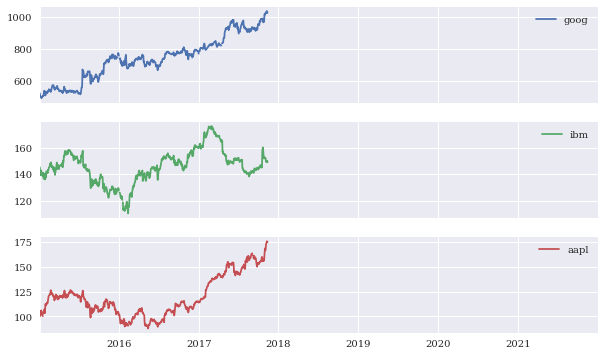

In [3]:
dates = pd.date_range('2015-01-02','2022-01-01',freq='B')
symbols = ['goog','ibm','aapl']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.plot(figsize=(10, 6), subplots=True);

In [4]:
df.head()

,goog,ibm,aapl
2015-01-02,524.81,145.54,103.50
2015-01-05,513.87,143.24,100.58
2015-01-06,501.96,140.14,100.59
2015-01-07,501.10,139.23,102.01
2015-01-08,502.68,142.26,105.93


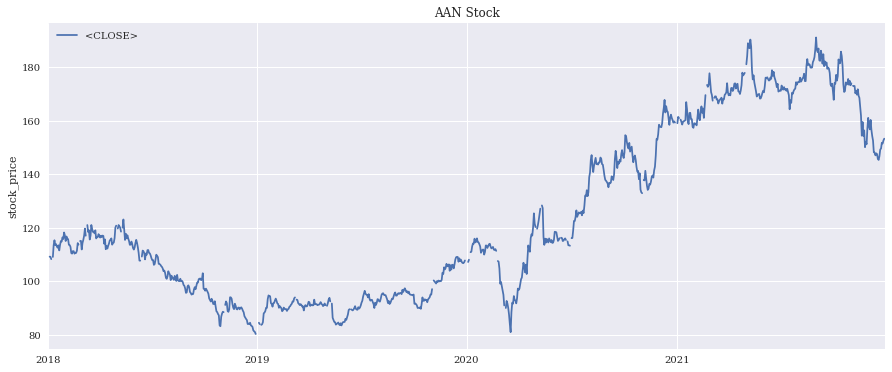

In [261]:
dates = pd.date_range('2018-01-01','2022-01-02',freq='B')
df1=pd.DataFrame(index=dates)
# df_ibm=pd.read_csv("../Stocks/ibm.us.txt", parse_dates=True, index_col=0)
df_ibm=pd.read_csv("MOEX.csv",header=0, sep=';', parse_dates=True, index_col=2)

df_ibm=df1.join(df_ibm)
df_ibm[['<CLOSE>']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("AAN Stock")
plt.show()

In [262]:
df_ibm.head()

,<TICKER>,<PER>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,MOEX,D,0.0,109.25,110.42,108.3,109.18,8602720.0
2018-01-04,MOEX,D,0.0,109.13,109.80,108.5,109.12,9840610.0
2018-01-05,MOEX,D,0.0,109.17,109.36,108.0,108.25,7163440.0


In [263]:
df_ibm_close=df_ibm[['<CLOSE>']]
df_ibm_high=df_ibm[['<HIGH>']]
df_ibm_low=df_ibm[['<LOW>']]


df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1045 entries, 2018-01-01 to 2021-12-31
Freq: B
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <TICKER>  1007 non-null   object 
 1   <PER>     1007 non-null   object 
 2   <TIME>    1007 non-null   float64
 3   <OPEN>    1007 non-null   float64
 4   <HIGH>    1007 non-null   float64
 5   <LOW>     1007 non-null   float64
 6   <CLOSE>   1007 non-null   float64
 7   <VOL>     1007 non-null   float64
dtypes: float64(6), object(2)
memory usage: 105.8+ KB


In [264]:
df_ibm_close=df_ibm_close.dropna() #fillna(method='ffill')
df_ibm_high=df_ibm_high.dropna() #.fillna(method='ffill')
df_ibm_low=df_ibm_low.dropna() #.fillna(method='ffill')


scaler_close = MinMaxScaler(feature_range=(-1, 1))
df_ibm_close['<CLOSE>'] = scaler_close.fit_transform(df_ibm_close['<CLOSE>'].values.reshape(-1,1))
scaler_high = MinMaxScaler(feature_range=(-1, 1))
df_ibm_high['<HIGH>'] = scaler_high.fit_transform(df_ibm_high['<HIGH>'].values.reshape(-1,1))
scaler_low = MinMaxScaler(feature_range=(-1, 1))
df_ibm_low['<LOW>'] = scaler_low.fit_transform(df_ibm_low['<LOW>'].values.reshape(-1,1))
#df_ibm

In [265]:
df_ibm_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2018-01-03 to 2021-12-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   <CLOSE>  1007 non-null   float64
dtypes: float64(1)
memory usage: 15.7 KB


In [266]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[1:train_set_size,:-1,:]
    y_train = data[1:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train_low, y_train_low, x_test_low, y_test_low = load_data(df_ibm_low, look_back)
x_train_high, y_train_high, x_test_high, y_test_high = load_data(df_ibm_high, look_back)
x_train_close, y_train_close, x_test_close, y_test_close = load_data(df_ibm_close, look_back)

# print('x_train.shape = ',x_train.shape)
# print('y_train.shape = ',y_train.shape)
# print('x_test.shape = ',x_test.shape)
# print('y_test.shape = ',y_test.shape)

In [267]:
x_train_close.shape

(757, 59, 1)

In [268]:
np.concatenate([x_train_low, x_train_high, x_train_close]

SyntaxError: unexpected EOF while parsing (550518550.py, line 1)

In [269]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train_close).type(torch.Tensor)
x_test = torch.from_numpy(x_test_close).type(torch.Tensor)
y_train = torch.from_numpy(y_train_close).type(torch.Tensor)
y_test = torch.from_numpy(y_test_close).type(torch.Tensor)

In [270]:
y_train.size(),x_train.size()

(torch.Size([757, 1]), torch.Size([757, 59, 1]))

## 3. Build the structure of model

In [271]:
# Build model
#####################
input_dim = 1
hidden_dim = 128
num_layers = 8
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to('cuda')

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to('cuda')

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to('cuda')

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.0005)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 128, num_layers=8, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
34
torch.Size([512, 1])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([1, 128])
torch.Size([1])


In [272]:
from tqdm import tqdm
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in tqdm(range(num_epochs)):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train.to('cuda'))

    loss = loss_fn(y_train_pred, y_train.to('cuda'))
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

  6%|████▍                                                                            | 11/200 [00:02<00:48,  3.87it/s]

Epoch  10 MSE:  0.21170423924922943


 10%|████████▌                                                                        | 21/200 [00:05<00:45,  3.90it/s]

Epoch  20 MSE:  0.21005822718143463


 16%|████████████▌                                                                    | 31/200 [00:07<00:43,  3.90it/s]

Epoch  30 MSE:  0.2042120099067688


 20%|████████████████▌                                                                | 41/200 [00:10<00:40,  3.88it/s]

Epoch  40 MSE:  0.18281354010105133


 26%|████████████████████▋                                                            | 51/200 [00:13<00:39,  3.78it/s]

Epoch  50 MSE:  0.0950617641210556


 30%|████████████████████████▋                                                        | 61/200 [00:15<00:36,  3.83it/s]

Epoch  60 MSE:  0.048133932054042816


 36%|████████████████████████████▊                                                    | 71/200 [00:18<00:33,  3.87it/s]

Epoch  70 MSE:  0.02441052533686161


 40%|████████████████████████████████▊                                                | 81/200 [00:21<00:30,  3.86it/s]

Epoch  80 MSE:  0.018191233277320862


 46%|████████████████████████████████████▊                                            | 91/200 [00:23<00:28,  3.86it/s]

Epoch  90 MSE:  0.015964718535542488


 50%|████████████████████████████████████████▍                                       | 101/200 [00:26<00:25,  3.84it/s]

Epoch  100 MSE:  0.012321787886321545


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:28<00:23,  3.82it/s]

Epoch  110 MSE:  0.009855047799646854


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:31<00:20,  3.82it/s]

Epoch  120 MSE:  0.008671778254210949


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:34<00:17,  3.84it/s]

Epoch  130 MSE:  0.00775089580565691


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:36<00:15,  3.81it/s]

Epoch  140 MSE:  0.007241057697683573


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:39<00:12,  3.83it/s]

Epoch  150 MSE:  0.0067188916727900505


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:41<00:10,  3.83it/s]

Epoch  160 MSE:  0.0062489896081388


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:44<00:07,  3.81it/s]

Epoch  170 MSE:  0.005827062297612429


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:47<00:05,  3.80it/s]

Epoch  180 MSE:  0.00560042355209589


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:49<00:02,  3.77it/s]

Epoch  190 MSE:  0.005543918814510107


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:52<00:00,  3.84it/s]


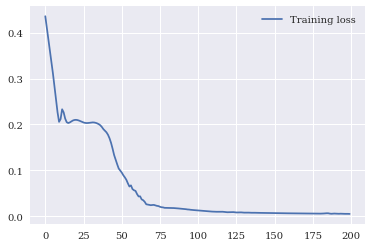

In [273]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [274]:
# make predictions
y_test_pred = model(x_test.to('cuda'))

# invert predictions
y_train_pred = scaler_close.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler_close.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler_close.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler_close.inverse_transform(y_test.detach().cpu().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.89 RMSE
Test Score: 6.47 RMSE


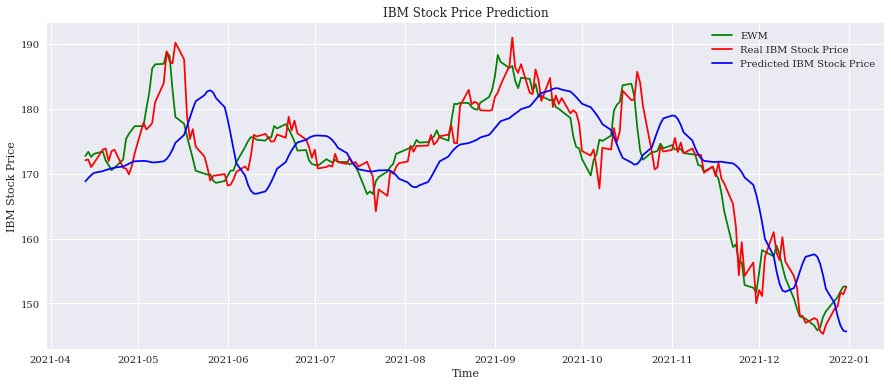

In [275]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

# axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, scaler.inverse_transform(df_ibm[len(df_ibm)-len(y_test):].values).ewm(com=0.8).mean().values, color = 'red', label = 'EWM Price')

axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, df_ibm['<CLOSE>'].ewm(com=0.8).mean()[-189:].values, color = 'green', label = 'EWM')
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test, color = 'red', label = 'Real IBM Stock Price')
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.savefig('ibm_pred.png')
plt.show()

In [209]:
y_test.shape

(189, 1)

In [210]:
y_test_low = scaler_low.inverse_transform(y_test_low)
y_test_high= scaler_high.inverse_transform(y_test_high)



In [211]:
book_size_long = 100
book_size_short = -100
value = 0
hold = 0
commision = 0.000025
current_price = y_test_pred.squeeze()[0]
for predicted_price, real_price, high, low in zip(y_test_pred[1:].squeeze(), y_test[1:].squeeze(), y_test_high.squeeze()[1:], y_test_low.squeeze()[1:]):
    if predicted_price < current_price and hold > book_size_short :
        # sell
        number_actions = (hold - book_size_short) 
        hold = book_size_short
        transaction = low * number_actions
        value +=  (1 - commision) * transaction
        
    elif predicted_price > current_price and hold < book_size_long :
        # buy
        number_actions = (book_size_long - hold) 
        hold = book_size_long
        transaction = high * number_actions
        value -=  (1 + commision) * transaction
    current_price = predicted_price
if hold > 0:
    value += (1 - commision) * low * hold 
    hold = 0
    
if hold < 0:
    value -= (1 + commision) * high * hold 
    hold = 0
    
print(value)
print(hold)

-4889.882524999988
0
